# Import Packages

In [1]:
import time,os
%matplotlib inline                         
#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold


## Import Data

In [3]:
import h2o
h2o.connect()
xy_train = h2o.import_file(path = os.path.realpath("../input/h2o_xy_CemoRes_IAMG.csv"))

Connecting to H2O server at http://localhost:54321... successful.


--------------------------  -----------------------------
H2O cluster uptime:         1 day 0 hours 51 mins
H2O cluster version:        3.10.4.8
H2O cluster version age:    3 months and 14 days !!!
H2O cluster name:           H2O_from_python_jethva_sv30wf
H2O cluster total nodes:    1
H2O cluster free memory:    30.19 Gb
H2O cluster total cores:    24
H2O cluster allowed cores:  24
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.6.0 final
--------------------------  -----------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
xy_train_df = xy_train.as_data_frame(use_pandas=True)
print (xy_train_df.shape)

(57, 13333)


In [14]:
xy_train_df.iloc[0:2,0:2]

C1  GYPE.rawXN
0  AGG600716   20.354145
1  ANO420520   57.977260

In [15]:
xy_train_df.iloc[0:2,0:2].values

array([['AGG600716', 20.354145000000003],
       ['ANO420520', 57.97726]], dtype=object)

In [16]:
xy_train[0:2,0:2]

C1 GYPE.rawXN 
 
 
 AGG600716 20.3541 
 ANO420520 57.9773

In [5]:
X = xy_train.col_names[0:13330]
y = xy_train.col_names[13330]
y

'Relapse01'

# variance

In [6]:
threshold = (.8 * (1 - .8))
sel = VarianceThreshold(threshold=(.8 * (1 - .8))) #  more than 80% of the samples have same value in spesific feature

In [17]:
xy_train_np_vari_x = sel.fit_transform(xy_train_df[X[1:]].values)

In [19]:
print(xy_train_df[X[1:]].values.shape)
print(xy_train_np_vari_x.shape)

(57, 13329)
(57, 9555)


In [24]:
bool_mask = sel.variances_ > threshold
idx = np.where(sel.variances_ > threshold)[0]

In [45]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]


In [47]:
print(idx.shape)
print((idx+1).astype(int)[0:])
selected_colnames = []
for i in (idx+1).astype(int):
    selected_colnames.append(X[i])

print(selected_colnames[0:5])
removed_colnames = diff(X[1:],selected_colnames)
print(removed_colnames[0:5])

(9555,)
[    1     2     3 ..., 13325 13326 13328]
['GYPE.rawXN', 'NLRP3.rawXN', 'MAP3K5.rawXN', 'CCL25.rawXN', 'MAEA.rawXN']
['GYPE.normPXN', 'NLRP3.normPXN', 'MAP3K5.normPXN', 'CCL25.normPXN', 'PTEN.normPXN']


# Information Gain

## Tree-based feature selection

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


In [51]:
clf = ExtraTreesClassifier()
clf = clf.fit(xy_train_df[X[1:]].values, xy_train_df[y].values) 
varimp_np = clf.feature_importances_  

In [64]:
clf.score(xy_train_df[X[1:]].values, xy_train_df[y].values)

1.0

In [67]:
clf.decision_path(xy_train_df[X[1:]].values)

(<57x262 sparse matrix of type '<class 'numpy.int64'>'
 	with 3381 stored elements in Compressed Sparse Row format>,
 array([  0,  25,  52,  77, 102, 131, 156, 183, 210, 237, 262]))

In [54]:
varimp_df = pd.DataFrame(varimp_np,index=X[1:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0667a54940>]], dtype=object)

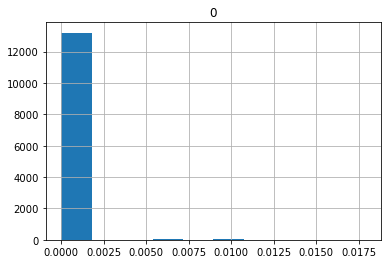

In [56]:
varimp_df.hist()

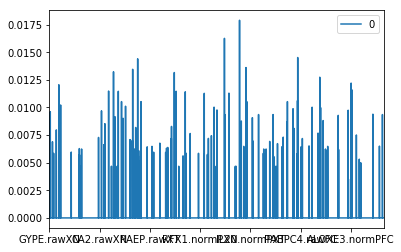

In [57]:
varimp_df.plot()

In [58]:
varimp_df.to_csv("RF_imp.csv")

## L1-based feature selection

In [68]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [69]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(xy_train_df[X[1:]].values, xy_train_df[y].values)


In [70]:
lsvc.score(xy_train_df[X[1:]].values, xy_train_df[y].values)

1.0

In [74]:
lsvc.coef_.T.shape

(13329, 1)

In [75]:
varCoef_df = pd.DataFrame(lsvc.coef_.T,index=X[1:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0665d210b8>]], dtype=object)

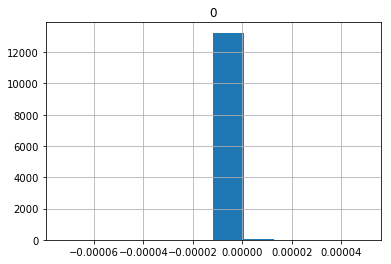

In [76]:
varCoef_df.hist()

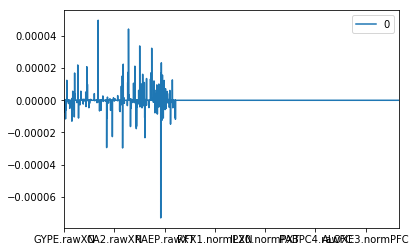

In [77]:
varCoef_df.plot()

In [79]:
varCoef_df.to_csv("SVM_l1_imp.csv")

## logistic regression

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
logr = LogisticRegression(C=0.01, penalty="l1", dual=False).fit(xy_train_df[X[1:]].values, xy_train_df[y].values)

In [83]:
logr.score(xy_train_df[X[1:]].values, xy_train_df[y].values)

1.0

In [84]:
varCoef_logr_df = pd.DataFrame(logr.coef_.T,index=X[1:])

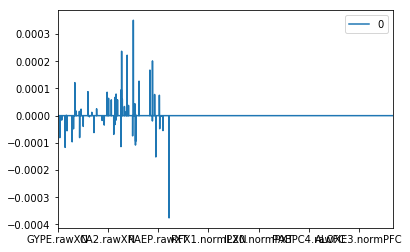

In [85]:
varCoef_logr_df.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0651a6be80>]], dtype=object)

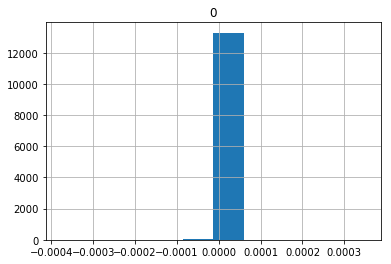

In [86]:
varCoef_logr_df.hist()

In [87]:
varCoef_logr_df.to_csv("logr_l1_imp.csv")

## Recursive feature elimination

In [88]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [89]:
# Create the RFE object and rank each feature
svc = SVC(kernel="linear", C=0.1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(xy_train_df[X[1:]].values, xy_train_df[y].values)
ranking = rfe.ranking_

In [91]:
ranking.shape

(13329,)

In [92]:
varRank_rfe_svm_l2_df = pd.DataFrame(ranking,index=X[1:])

In [93]:
varRank_rfe_svm_l2_df.to_csv("varRank_rfe_svm_l2_imp.csv")

## select best rank ANOVA

In [94]:
from sklearn.feature_selection import SelectKBest

In [95]:
sbf = SelectKBest(k="all")

In [96]:
sbf.fit(xy_train_df[X[1:]].values, xy_train_df[y].values)

/storage/users/jethva/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 5163  7384 11826] are constant.
  UserWarning)
/storage/users/jethva/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k='all', score_func=<function f_classif at 0x7f06910896a8>)

In [99]:
sbf_score_pval_df = pd.DataFrame({"pval":sbf.pvalues_,"score":sbf.scores_},index=X[1:],columns=["pval","score"])

In [100]:
sbf_score_pval_df.head()

pval     score
GYPE.rawXN    0.080460  3.171423
NLRP3.rawXN   0.714812  0.134902
MAP3K5.rawXN  0.379287  0.785621
CCL25.rawXN   0.811020  0.057726
MAEA.rawXN    0.159361  2.035052

In [101]:
sbf_score_pval_df.to_csv("score_sbf_imp.csv")

## chi2

In [102]:
from sklearn.feature_selection import chi2

In [103]:
chi_model = chi2(xy_train_df[X[1:]].values, xy_train_df[y].values)

In [107]:
chi2_score_pval_df = pd.DataFrame({"pval":chi_model[1],"score":chi_model[0]},index=X[1:],columns=["pval","score"])
chi2_score_pval_df.head()

pval       score
GYPE.rawXN     1.188713e-26  114.182156
NLRP3.rawXN    1.557799e-06   23.075290
MAP3K5.rawXN   1.663507e-38  168.389045
CCL25.rawXN    4.178761e-01    0.656281
MAEA.rawXN    5.428551e-108  487.330427

In [108]:
chi2_score_pval_df.to_csv("score_chi2_imp.csv")